In [ ]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/Time series/top_10_stock_data.csv")
data.head(1)

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,AAPL,27.8475,27.860001,26.8375,27.3325,24.373959,212818400


Epoch 1/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 83s 241ms/step - loss: 0.0205 - mae: 0.0915 - val_loss: 0.0072 - val_mae: 0.0497
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 86s 256ms/step - loss: 0.0026 - mae: 0.0356 - val_loss: 0.0034 - val_mae: 0.0374
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 77s 241ms/step - loss: 0.0017 - mae: 0.0291 - val_loss: 2.7048e-04 - val_mae: 0.0133
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - loss: 0.0014 - mae: 0.0254 - val_loss: 2.2101e-04 - val_mae: 0.0103
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 73s 234ms/step - loss: 0.0012 - mae: 0.0232 - val_loss: 7.6327e-04 - val_mae: 0.0191
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 84s 243ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 1.4716e-04 - val_mae: 0.0079
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 75s 240ms/step - loss: 9.3255e-04 - mae: 0.0204 - val_loss: 3.1531e-04 - val_mae: 0.0124
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 76s 222ms/step - loss: 8.9380e-04 - mae: 0.0201 - val_loss: 2.4887e-04 - val_mae:

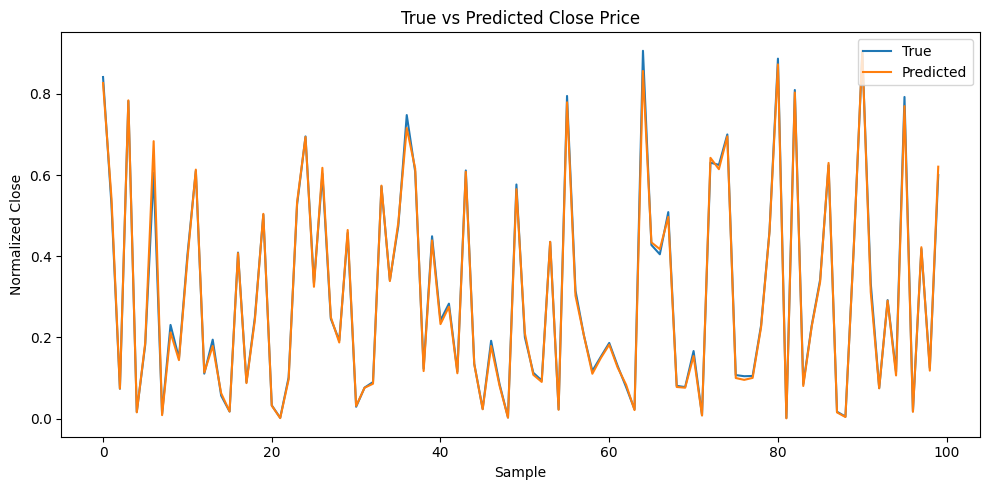

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, Add, BatchNormalization, Dropout, LSTM, MultiHeadAttention, LayerNormalization, Conv1DTranspose
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("/content/drive/MyDrive/Time series/top_10_stock_data.csv")

SEQ_LEN = 60
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
TARGET = 'Close'

def create_sequences(df, seq_len=60):
    X, y = [], []
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values("Date")
        values = group[FEATURES].values
        if len(values) <= seq_len:
            continue
        scaler = MinMaxScaler()
        values_scaled = scaler.fit_transform(values)
        for i in range(len(values_scaled) - seq_len):
            X.append(values_scaled[i:i+seq_len])
            y.append(values_scaled[i+seq_len][FEATURES.index(TARGET)])
    return np.array(X), np.array(y).reshape(-1, 1)

X_all, y_all = create_sequences(df, seq_len=SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

def residual_cnn_block(inputs):
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    shortcut = Conv1D(filters=64, kernel_size=1, padding="same")(inputs)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    return x

def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = Dropout(dropout)(attn)
    out1 = Add()([attn, inputs])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([ffn, out1])
    return LayerNormalization(epsilon=1e-6)(out2)

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = residual_cnn_block(inputs)
    x = transformer_block(x)
    x = LSTM(64)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])
    return model

model = build_model(X_train.shape[1:])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

direction_true = np.sign(y_test[1:] - y_test[:-1])
direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
directional_accuracy = np.mean(direction_true == direction_pred) * 100

print(f"\n--- Evaluation Metrics ---")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# ===============================
# Plot Results
# ===============================
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="True")
plt.plot(y_pred[:100], label="Predicted")

# Updated title (removed file name)
plt.title("True vs Predicted Close Price")

plt.xlabel("Sample")
plt.ylabel("Normalized Close")

# Legend moved to upper right
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
